# Convolutional kernels - blurring, thresholds, edge detection

In [112]:
# We need to include the home directory in our path, so we can read in our own module.
import os
import sys
sys.path.append(os.path.join(".."))
import cv2
import numpy as np
from utils.imutils import jimshow
from utils.imutils import jimshow_channel
import matplotlib.pyplot as plt

### Load image

Let's start by loading our dino buddy.

In [113]:
filename = os.path.join("..", "data", "img", "trex.png")
#just tried using the image of the wave --> looks absolutely terrible 

In [114]:
image = cv2.imread(filename)

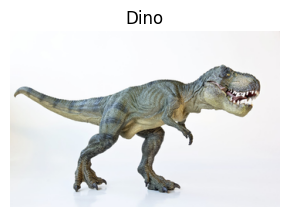

In [115]:
jimshow(image, "Dino")

## Blurring and convolutions

```OpenCV``` has built in functions for performing blurring.

All we need to do is choose which blurring method we want, and some parameters which define the blur.

__Averaging__

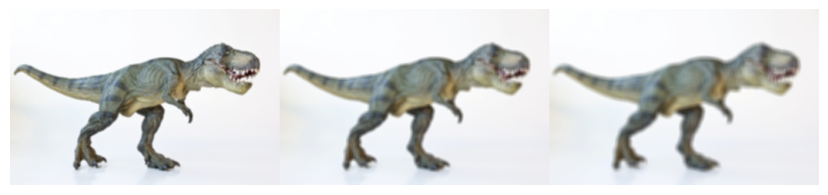

In [116]:
blurred = np.hstack([#visualizing 3 blurrs next to eachother 
    cv2.blur(image, (3, 3)),
    cv2.blur(image, (5, 5)),
    cv2.blur(image, (7, 7))]
    )
jimshow(blurred)

__Gaussian__

Third parameter relates to variance around the mean for a Gaussian distribution. For our purposes, we can just set that to ```0```.


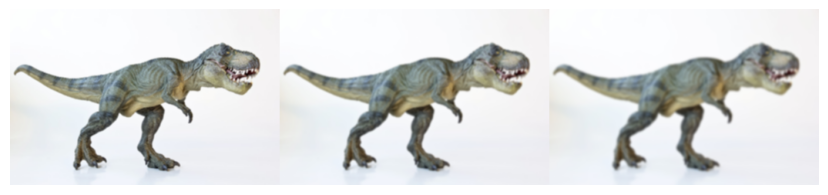

In [117]:
# gaussian blur
blurred = np.hstack([
    cv2.GaussianBlur(image, (3, 3), 0), #3,3 means we're using a 3x3 kernel
    cv2.GaussianBlur(image, (5, 5), 0), #5x5 kernel
    cv2.GaussianBlur(image, (7, 7), 0)] #7x7 kernel
    )
jimshow(blurred)

__Median__

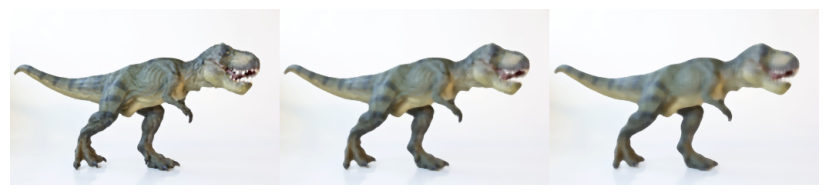

In [118]:
#does not "invent" pixel values, kernel removes details and noise
blurred = np.hstack([
    cv2.medianBlur(image, 3),
    cv2.medianBlur(image, 5),
    cv2.medianBlur(image, 7)]
    ) # a single value is put in here: 3 --> i just mean we use a 3x3 kernel
jimshow(blurred)

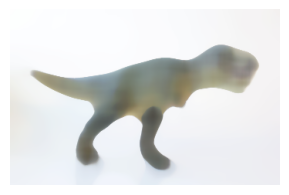

In [119]:
## trying to fiddle around with blur, here we have 27x27 kernel MEDIAN blur
jimshow(cv2.medianBlur(image, 27))

## Thresholding

As with blurring, ```OpenCV``` has built in functions for allowing us to perform thresholding. However, we need to perform another couple of steps before we get there.

__Simple thresholding__

We'll start by reloading the image and converting to greyscale with ```cv2.cvtColor()``` like we saw a couple of weeks back.

In [120]:
image = cv2.imread(filename)

In [121]:
# convert to greyscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #BGR to GRAY

When using simple thresholding, we want to set a single specific value above which everything is set to white and below which everything is set to black.

How do we determine the value?

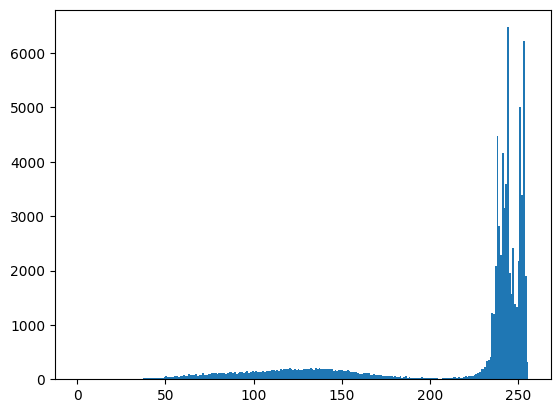

In [122]:
# plot histogram
plt.hist(image.flatten(),256,[0,256])
plt.show() #in this plot we see, that the vast majority in the picture is white
# and values from 50-200 is basically the cute lil dino <3
#so here we can use the information from the histogram for setting threshold!
# so theres a clear boundry between the dino and the background (white), so the threshold would probably be around 200 :)

__Blur the image__

To get the best results for our edge detection, we first need to blur our image to smooth out the noise.

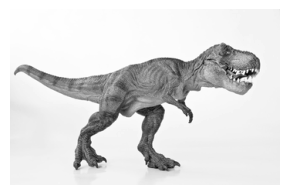

In [123]:
# remove high frequency edges with a blur kernel
blurred = cv2.GaussianBlur(image, (5, 5), 0) #5x5 gaussian blur kernel
jimshow_channel(image)

Once we've blurred the image, we then use the ```cv2.threshold()``` function to perform simple thresholding using our predetermined binary threshold.

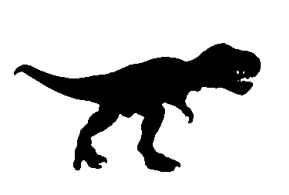

In [124]:
# threshold 
(T, thres) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY) #with blured img, set threshold to 200,
# so anything above this threshold  == 255 (white)
jimshow_channel(thres)

#NOTE: it returns both a T and thres :) 
# the T = threshold
# the thres = the img with the applied threshold criteria

This gives us a black sillhouette on a white background. However, when working with a mask, we want the opposite because we're using ```bitwise_AND```.

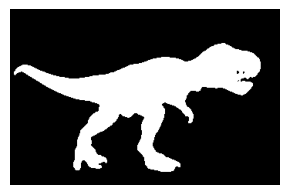

In [125]:
(T, thresInv) = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV) # Now we invert it (make it a MASK)
jimshow_channel(thresInv)

We can then display the image using the mask generated by our simple threshold.

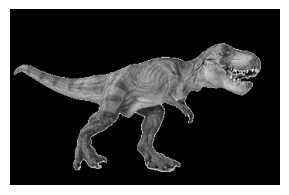

In [126]:
jimshow_channel(cv2.bitwise_and(image, image, mask = thresInv))

__Adaptive__

The exact same steps are required when performing adaptive thresholding. We load the image, make it greyscale, and use blurring. 

The only difference is that, this time, we use the ```cv2.adaptiveThreshold()``` function.

In [127]:
image = cv2.imread(filename)

In [128]:
# preprocessing
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #make grey
blurred = cv2.GaussianBlur(image_grey, (5,5), 0) #blur

__Adaptive mean threshold__

The ```cv2.adaptiveTreshold()``` function requires slightly different combinations of arguments, outlined below.

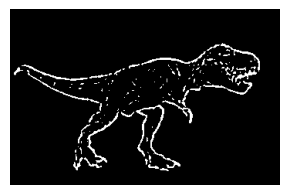

In [129]:
am_thresh = cv2.adaptiveThreshold(blurred, 
    255,                            # set values above threshold to white
    cv2.ADAPTIVE_THRESH_MEAN_C,     # method for computing threshold (mean of neighborhood) 
    cv2.THRESH_BINARY_INV,          # method for thresholding 
    5,                              # neighborhood pixel size (5x5 grid of kernel)
    10                              # parameter C subtracted from the mean to fine-tune thresholding (used for finetuning, try setting it to 4 = it becomes more noisy, but also 12 is not too good)
    )
jimshow_channel(am_thresh)

#this method, is a bit more delicate, because we can tweek parameters in the edge detection

Once we've found the edges, we can then use it as a mask, just as with simple thresholding.

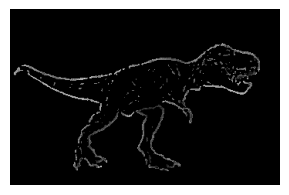

In [130]:
jimshow_channel(cv2.bitwise_and(image_grey, image_grey, mask = am_thresh))

## Edge Detection

Edge detection follows a similar set of steps again. We always begin by loading the image and making it greyscale.

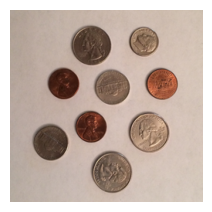

In [131]:
newfile = os.path.join("..", "data", "img", "coins.png")
image = cv2.imread(newfile)
jimshow(image)


In [132]:
#convert it to grey scale
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## Sobel operators

We can use the ```cv2.Sobel()``` function to define horiztonal and vertical sobel kernels.

In [133]:
# Sobel operatator
sobelX = cv2.Sobel(grey, cv2.CV_64F, 1, 0)  # horizontal kernel (1,0) = means horizontal kernel
sobelY = cv2.Sobel(grey, cv2.CV_64F, 0, 1)  # vertical kernel (0,1) means vertical kernel

Notice that here we're using 64-bit floating point numbers, while all of our pixel values are actually unsigned 8-bit integers. The reason for this is that ```float64``` values can show much more finegrained variation, which allow us to detect edges much more accurately.

In order to work with the edges for the rest of our workflow, we need to convert back to unsiged integers, which we can do in the following way:

In [134]:
sobelX = np.uint8(np.absolute(sobelX)) #we take the absolute values in order to get rid of negative numbers :) so -3 becomes 3
sobelY = np.uint8(np.absolute(sobelY))

#ross:  this is confusing and pointless (because laplacian kernels tends to perform better :))

We can then see how these look:

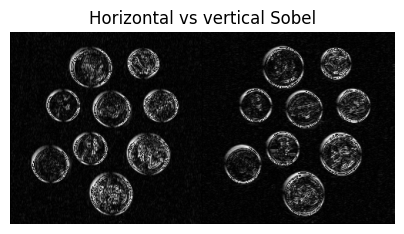

In [135]:
blurred = np.hstack([sobelX, sobelY])
jimshow_channel(blurred, "Horizontal vs vertical Sobel")

## Combined Sobel

In order to combine the gradient images in both the x and y direction, we can apply a bitwise OR. 

Remember, an OR operation is true when either pixel is greater than zero. 

Therefore, a given pixel will be ```True``` if either a horizontal or vertical edge is present.

In [136]:
sobelCombined = cv2.bitwise_or(sobelX, sobelY) #basically just using both the vertical and horizsontal sobel operator
#using he bitwise operator or == take the pixel there both sobelX AND sobelY is above threshold and convert to X :)

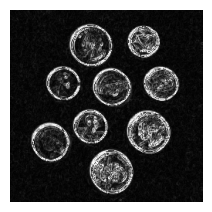

In [137]:
jimshow_channel(sobelCombined)

## Laplacian

Laplacian operator returns a single gradient, no need to perform two passes.

In [138]:
#laplacian to compute gradient magnitude
lap = cv2.Laplacian(grey, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))

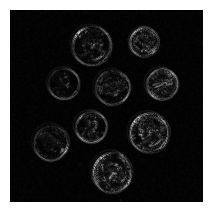

In [139]:
jimshow_channel(lap) #getting rid of most variation in the coins, compared to the combined sobel


#this is basically operatons on matrices and numbers with matrices and numbers 